In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from keras.layers import Dropout

# load dataset 
pathLyrics = 'lyrics-data.csv'
pathArtists = 'artists-data.csv'


dataframe = pd.read_csv(pathLyrics)
dataframeArtists = pd.read_csv(pathArtists)

Using TensorFlow backend.


#Data preparation

In [2]:
from sklearn.utils import shuffle

dataframe = dataframe[dataframe['Idiom'] == 'ENGLISH']
dataframe['Lyric'] = dataframe['Lyric'].apply(lambda lyric: lyric.lower())


patternDel = ["---", "instrumental","==="]
for patt in patternDel:
    filter = dataframe['Lyric'].str.contains(patt)
    dataframe = dataframe[~filter]

dataframe.rename(columns={'ALink':'Link','SName':'SName', 'SLink':'SLink','Lyric':'Lyric','Idiom':'Idiom'},inplace=True)
mergeData=pd.merge(dataframe, dataframeArtists, on='Link')
listOfIndex=[]

for ind in mergeData.index:
    if type(mergeData['Genres'][ind]) is str: 
        s_gerne = mergeData['Genre'][ind]
        #print(type(mergeData['Genres'][ind]))
        s_gernres = mergeData['Genres'][ind].split(";")
        if s_gerne !=  s_gernres[0]:
            listOfIndex.append(ind)
    else:
        listOfIndex.append(ind)
        
        
mergeData.drop(listOfIndex,inplace=True )
#mergeData.to_csv('merge.csv')
rawData = shuffle(mergeData)


#Baseline

In [3]:
vectorizer = CountVectorizer()
X_cnt = vectorizer.fit_transform(rawData['Lyric'])

label_encoder = LabelEncoder()
y_clean = label_encoder.fit_transform(rawData['Genre'])

X_train, X_test, y_train, y_test = train_test_split(X_cnt, y_clean, test_size=0.2, random_state=0)

## Naive Bayes mit additiver Glättung trainieren
nb = MultinomialNB(alpha=1.0)
nb.fit(X_train, y_train)

## Vorhersagen berechnen
y_predicted = nb.predict(X_test)


## Konfusionsmatrix ausgeben
print("Kofusionsmatrix:\n", confusion_matrix(y_true=y_test, y_pred=y_predicted))

## Gütemaße ausgeben
print("Korrektklassifizierungsrate:\n", accuracy_score(y_true=y_test, y_pred=y_predicted))
print("Präzision (mikro):\n", precision_score(y_true=y_test, y_pred=y_predicted, average='micro'))
print("Ausbeute (mikro):\n", recall_score(y_true=y_test, y_pred=y_predicted, average='micro'))
print("F1 (mikro):\n", f1_score(y_true=y_test, y_pred=y_predicted, average='micro'))

Kofusionsmatrix:
 [[   0    0    2    0    0    0]
 [   0 1592  570  132    0    0]
 [   0  265 2422 1236    0    5]
 [   1  223 1357 4509    0    4]
 [   0    1    4    4    0    0]
 [   0    0    5    8    0    0]]
Korrektklassifizierungsrate:
 0.6906807131280389
Präzision (mikro):
 0.6906807131280389
Ausbeute (mikro):
 0.6906807131280389
F1 (mikro):
 0.6906807131280389


#Feed Forward Network

In [4]:
def vectorize_sequences (dataframe, dimensions=10000):
    vect = CountVectorizer()
    X = vect.fit_transform(dataframe)
    tokenizer = Tokenizer(num_words=dimensions, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
    tokenizer.fit_on_texts(dataframe)
    sequences = tokenizer.texts_to_sequences(dataframe)
    one_hot_results = tokenizer.texts_to_matrix(dataframe, mode='binary')
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    return one_hot_results
    
def vectorize_labels(labels):
    le = preprocessing.LabelEncoder()
    encodedlabels = le.fit(labels)
    encodedlabels_transformed= le.transform(labels) 
    return to_categorical(encodedlabels_transformed)

In [6]:
X_cnt = vectorize_sequences(rawData['Lyric'])
#y_train = vectorize_sequences(train['Genre'], 6)
y_clean = vectorize_labels(rawData['Genre'])

X_train, X_test, y_train, y_test = train_test_split(X_cnt, y_clean, test_size=0.2, random_state=0)

Found 101195 unique tokens.


In [7]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 102       
Total params: 160,390
Trainable params: 160,390
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model.fit(X_train, y_train, epochs=50,batch_size=100, validation_split=0.2)

Train on 39487 samples, validate on 9872 samples
Epoch 1/50
39487/39487 [==============================] - 9s 231us/step - loss: 1.1324 - accuracy: 0.5407 - val_loss: 0.7867 - val_accuracy: 0.6821
Epoch 2/50
39487/39487 [==============================] - 6s 142us/step - loss: 0.7307 - accuracy: 0.6917 - val_loss: 0.6986 - val_accuracy: 0.7000
Epoch 3/50
39487/39487 [==============================] - 6s 145us/step - loss: 0.6840 - accuracy: 0.7079 - val_loss: 0.6729 - val_accuracy: 0.7156
Epoch 4/50
39487/39487 [==============================] - 7s 187us/step - loss: 0.6585 - accuracy: 0.7206 - val_loss: 0.6518 - val_accuracy: 0.7238
Epoch 5/50
39487/39487 [==============================] - 8s 198us/step - loss: 0.6389 - accuracy: 0.7294 - val_loss: 0.6390 - val_accuracy: 0.7306
Epoch 6/50
39487/39487 [==============================] - 8s 200us/step - loss: 0.6226 - accuracy: 0.7357 - val_loss: 0.6282 - val_accuracy: 0.7353
Epoch 7/50
39487/39487 [==============================] - 8s 21

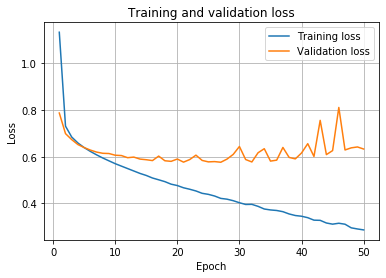

In [9]:
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation loss')
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [12]:

# compute loss and accuracy on test data
score = model.evaluate( X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

12340/12340 [==============================] - 2s 161us/step
Test score: 0.6490293280618504
Test accuracy: 0.7691248059272766


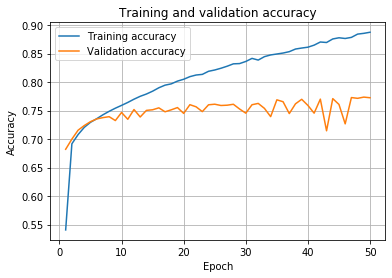

In [13]:
history_dict = history.history
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation accuracy')
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Enhanced FFN

In [290]:
tfidf_vectorizer=TfidfVectorizer(stop_words="english",max_features=10000, ngram_range=(1, 3),use_idf=True )

xtrain_tfidf = tfidf_vectorizer.fit(rawData['Lyric'])

X_cnt = xtrain_tfidf.transform(rawData['Lyric'])
y_clean = vectorize_labels(rawData['Genre'])



X_train, X_test, y_train, y_test = train_test_split(X_cnt, y_clean, test_size=0.2, random_state=0, shuffle=True)

In [294]:
model_tfidf = models.Sequential()
model_tfidf.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model_tfidf.add(layers.Dense(256, activation='relu'))
#model_tfidf.add(Dropout(0.01))
model_tfidf.add(layers.Dense(6, activation='softmax'))
model_tfidf.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
model_tfidf.summary()


Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_183 (Dense)            (None, 64)                640064    
_________________________________________________________________
dense_184 (Dense)            (None, 256)               16640     
_________________________________________________________________
dense_185 (Dense)            (None, 6)                 1542      
Total params: 658,246
Trainable params: 658,246
Non-trainable params: 0
_________________________________________________________________


In [295]:
history_tfidf = model_tfidf.fit(X_train, y_train, epochs=64, batch_size=64, validation_split=0.2)

Train on 39487 samples, validate on 9872 samples
Epoch 1/64
39487/39487 [==============================] - 7s 169us/step - loss: 1.2856 - accuracy: 0.4891 - val_loss: 1.0876 - val_accuracy: 0.5031
Epoch 2/64
39487/39487 [==============================] - 7s 174us/step - loss: 1.0665 - accuracy: 0.4912 - val_loss: 1.0372 - val_accuracy: 0.5031
Epoch 3/64
39487/39487 [==============================] - 9s 217us/step - loss: 1.0394 - accuracy: 0.4912 - val_loss: 1.0210 - val_accuracy: 0.5031
Epoch 4/64
39487/39487 [==============================] - 9s 230us/step - loss: 1.0242 - accuracy: 0.4912 - val_loss: 1.0047 - val_accuracy: 0.5031
Epoch 5/64
39487/39487 [==============================] - 9s 238us/step - loss: 1.0042 - accuracy: 0.4912 - val_loss: 0.9791 - val_accuracy: 0.5031
Epoch 6/64
39487/39487 [==============================] - 9s 240us/step - loss: 0.9713 - accuracy: 0.5095 - val_loss: 0.9392 - val_accuracy: 0.5545
Epoch 7/64
39487/39487 [==============================] - 10s 2

39487/39487 [==============================] - 12s 295us/step - loss: 0.5522 - accuracy: 0.7712 - val_loss: 0.6406 - val_accuracy: 0.7137
Epoch 56/64
39487/39487 [==============================] - 12s 306us/step - loss: 0.5501 - accuracy: 0.7716 - val_loss: 0.6301 - val_accuracy: 0.7241
Epoch 57/64
39487/39487 [==============================] - 17s 437us/step - loss: 0.5466 - accuracy: 0.7719 - val_loss: 0.6268 - val_accuracy: 0.7250
Epoch 58/64
39487/39487 [==============================] - 14s 366us/step - loss: 0.5424 - accuracy: 0.7718 - val_loss: 0.6327 - val_accuracy: 0.7239
Epoch 59/64
39487/39487 [==============================] - 20s 498us/step - loss: 0.5381 - accuracy: 0.7769 - val_loss: 0.6297 - val_accuracy: 0.7186
Epoch 60/64
39487/39487 [==============================] - 15s 379us/step - loss: 0.5356 - accuracy: 0.7766 - val_loss: 0.6375 - val_accuracy: 0.7231
Epoch 61/64
39487/39487 [==============================] - 15s 391us/step - loss: 0.5296 - accuracy: 0.7796 - va

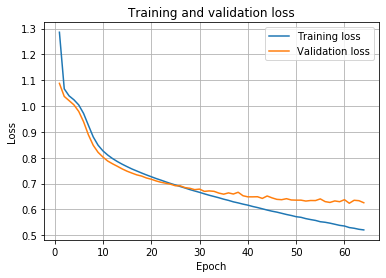

In [296]:
history_dict = history_tfidf.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation loss')
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [297]:
#xtest_tfidf = tfidf_vectorizer.fit(rawData['Lyric'])

#X_test = xtest_tfidf.transform(test['Lyric'])


#Y_test = vectorize_labels(test['Genre'])

# compute loss and accuracy on test data
score = model_tfidf.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

12340/12340 [==============================] - 2s 180us/step
Test score: 0.6407678432364131
Test accuracy: 0.7252026200294495


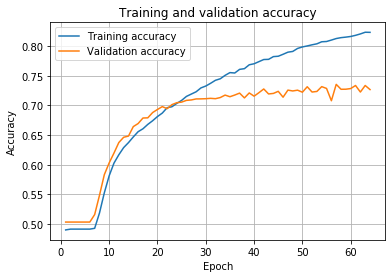

In [287]:
history_dict = history_tfidf.history
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation accuracy')
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

#Long short-term memory neural network

In [140]:

import numpy as np
from keras import models
from keras import layers
from tensorflow.keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Flatten
from keras.preprocessing import sequence


# number of most frequent words to consider
num_words = 10000

# maximum length of reviews (only the first so many words are considered)
max_len = 500

# embedding dimensionality
emb_dim = 32




In [277]:
tokenizer = Tokenizer(num_words=num_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(rawData['Lyric'])
sequences = tokenizer.texts_to_sequences(rawData['Lyric'])
X_clean = sequence.pad_sequences(sequences,maxlen=max_len)

Y_clean = vectorize_labels(rawData['Genre'])


X_train, X_test, y_train, y_test = train_test_split(X_clean, Y_clean, test_size=0.2, random_state=0, shuffle=True)

In [278]:
model = Sequential()
model.add(Embedding(num_words, emb_dim, input_length=max_len))
model.add(LSTM(16, recurrent_dropout=0.2, dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.summary() 

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train,y_train, epochs=15, batch_size=128, validation_split=0.2)



Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_173 (Dense)            (None, 6)                 102       
Total params: 323,238
Trainable params: 323,238
Non-trainable params: 0
_________________________________________________________________


G:\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 39487 samples, validate on 9872 samples
Epoch 1/15
39487/39487 [==============================] - 373s 9ms/step - loss: 1.1103 - acc: 0.4807 - val_loss: 1.0164 - val_acc: 0.5031
Epoch 2/15
39487/39487 [==============================] - 377s 10ms/step - loss: 0.9898 - acc: 0.5126 - val_loss: 0.9242 - val_acc: 0.5598
Epoch 3/15
39487/39487 [==============================] - 367s 9ms/step - loss: 0.8928 - acc: 0.5803 - val_loss: 0.8381 - val_acc: 0.6124
Epoch 4/15
39487/39487 [==============================] - 372s 9ms/step - loss: 0.8426 - acc: 0.6120 - val_loss: 0.8089 - val_acc: 0.6278
Epoch 5/15
39487/39487 [==============================] - 372s 9ms/step - loss: 0.7990 - acc: 0.6400 - val_loss: 0.7766 - val_acc: 0.6518
Epoch 6/15
39487/39487 [==============================] - 23775s 602ms/step - loss: 0.7523 - acc: 0.6742 - val_loss: 0.7249 - val_acc: 0.6889
Epoch 7/15
39487/39487 [==============================] - 406s 10ms/step - loss: 0.7155 - acc: 0.6928 - val_loss: 0.71

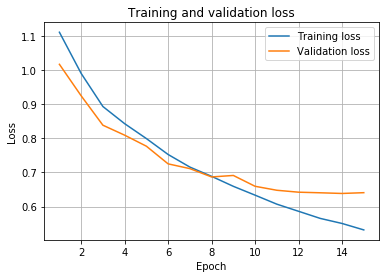

In [279]:
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation loss')
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [280]:
# compute loss and accuracy on test data
score = model.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

12340/12340 [==============================] - 77s 6ms/step
Test score: 0.6497974071935472
Test accuracy: 0.740275502204895


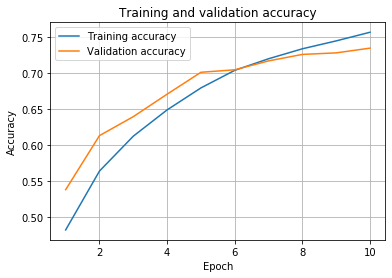

In [145]:
history_dict = history.history
train_acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation accuracy')
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()